# Análisis de Vulnerabilidad Externa con `latam_vulnerability_toolbox`

Este notebook demuestra el uso de la librería refactorizada para realizar el análisis completo, desde el cálculo del Índice de Términos de Intercambio de Commodities (CTOT) hasta la estimación de un modelo VECM y la generación del Indicador de Condiciones Externas.

## 1. Configuración e Importaciones

In [1]:
import os
import sys
import pandas as pd

# Añadir el directorio raíz al path para poder importar la librería
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

# Importar los módulos de nuestra librería
from latam_vulnerability_toolbox import ctot, data_loader, analysis, utils

# --- Configuración Principal ---
COUNTRY_NAME = 'Brasil'
COUNTRY_CODE = '76' # Código numérico de Brasil en UN Comtrade
COMTRADE_API_KEY = 'c058c869325841b5a762da7d9905e73e' # Reemplazar si es necesario

# Rutas a los ficheros de datos (relativas al directorio raíz del proyecto)
DATA_DIR = '../data'
IMF_PRICES_PATH = os.path.join(DATA_DIR, 'external-data.xls')
GDP_PATH = os.path.join(DATA_DIR, 'QGDP/brazil.csv')
MACRO_INDICATORS_PATH = os.path.join(DATA_DIR, 'indicadores/indicadores_macroeconomicos.csv')
CTOT_RESULTS_PATH = os.path.join(DATA_DIR, 'indicadores/monthly_results_brazil.csv')
HISTORICAL_TRADE_PATH = os.path.join(DATA_DIR, 'historical_trade_brasil.csv')

c:\Users\Usuario\anaconda3\envs\tftimeseriesII\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\Usuario\anaconda3\envs\tftimeseriesII\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
c:\Users\Usuario\anaconda3\envs\tftimeseriesII\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


## 2. Cálculo del Índice de Términos de Intercambio (CTOT)

Obteniendo datos de CPI del G7 desde OECD... Status: 200
Datos de CPI extraídos: 317 observaciones
CPI G7 convertido a base 2016=100.
Cargando datos de comercio desde el fichero local: ../data\historical_trade_brasil.csv
Mapeo exitoso: 6218/52737 registros (11.8%)

RESUMEN ESTADÍSTICO CTOT - BRASIL
Período: 2022-02 a 2025-05
Cambios Mensuales (% del PIB):
  - Media: -0.0317% | Mediana: -0.0663%
  - Desv. Est.: 0.3075% | Min: -1.0538% | Max: 0.5074%



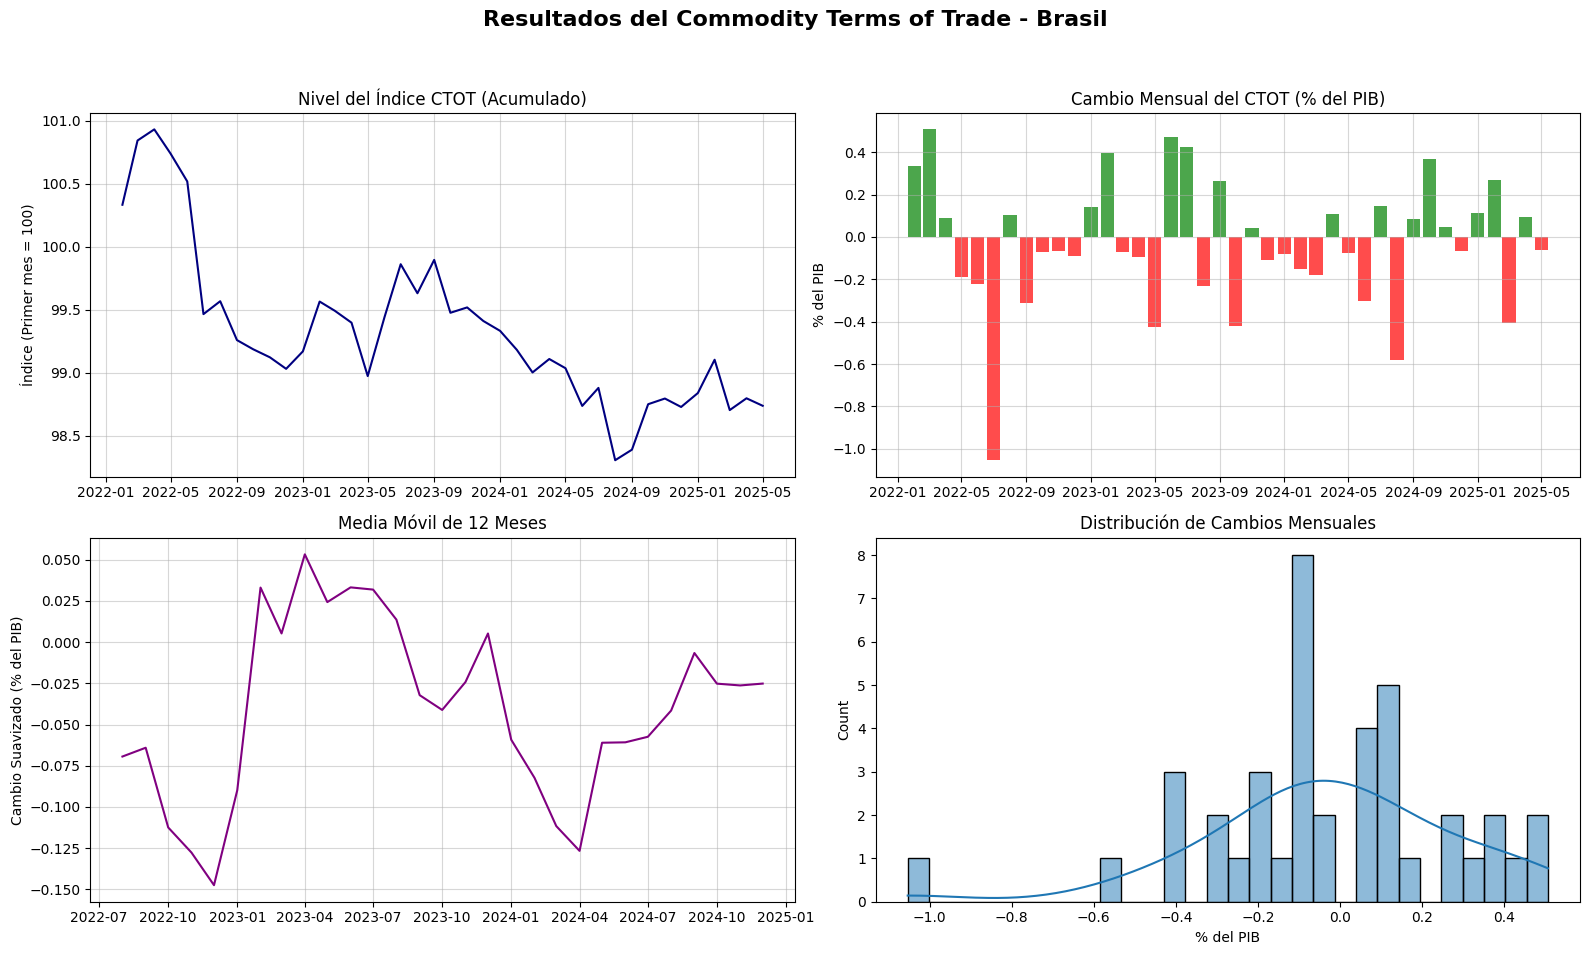

In [2]:
# Cargar datos de CPI desde OECD
cpi_g7_df = data_loader.get_oecd_cpi_data()
cpi_deflator = data_loader.prepare_cpi_deflator(cpi_g7_df)

# Cargar datos de comercio desde UN Comtrade (o usar un fichero cacheado para evitar descargas largas)
if os.path.exists(HISTORICAL_TRADE_PATH):
    print(f'Cargando datos de comercio desde el fichero local: {HISTORICAL_TRADE_PATH}')
    trade_df = pd.read_csv(HISTORICAL_TRADE_PATH, sep=';')
else:
    trade_df = data_loader.get_historical_trade_data(COMTRADE_API_KEY, COUNTRY_CODE, years=list(map(str, range(1997, 2025))))
    trade_df.to_csv(HISTORICAL_TRADE_PATH, index=False, sep=';')

# Cargar datos de PIB (para los pesos del CTOT)
gdp_df = pd.read_excel(os.path.join(DATA_DIR, 'gdp.xlsx'), index_col=0)
gdp_dict = gdp_df['Brazil'].to_dict()

# Instanciar y ejecutar la calculadora CTOT
calculator = ctot.MonthlyWP1921_CTOT_Calculator(config_path='../latam_vulnerability_toolbox/config')

imf_prices_df = calculator.load_imf_prices(IMF_PRICES_PATH, cpi_deflator=cpi_deflator)
mapped_trade = calculator.map_trade_to_commodities(trade_df)
annual_weights = calculator.calculate_annual_weights(mapped_trade, COUNTRY_CODE, gdp_dict)
tv_weights = calculator.calculate_time_varying_weights(annual_weights)
monthly_weights = calculator.interpolate_weights_to_monthly(tv_weights)
ctot_results = calculator.calculate_monthly_ctot(imf_prices_df, monthly_weights)

# Guardar y mostrar resultados del CTOT
ctot_results.to_csv(CTOT_RESULTS_PATH, sep=';', index=False)
utils.display_ctot_summary(ctot_results, COUNTRY_NAME)
utils.plot_ctot_results(ctot_results, COUNTRY_NAME)

## 3. Análisis de Vulnerabilidad con Modelo VECM

In [3]:
# Preparar los datos para el modelo VECM
model_df = analysis.create_model_dataframe(CTOT_RESULTS_PATH, MACRO_INDICATORS_PATH, GDP_PATH)
vecm_vars_df = analysis.prepare_vecm_variables(model_df)

# Realizar tests econométricos
analysis.perform_stationarity_tests(vecm_vars_df)
cointegration_rank = analysis.find_cointegration_rank(vecm_vars_df)

# Estimar el modelo y calcular resultados
if cointegration_rank > 0:
    vecm_results = analysis.estimate_vecm(vecm_vars_df, rank=cointegration_rank)
    indicator_df = analysis.calculate_indicator(vecm_results, vecm_vars_df)
    irf_results = analysis.calculate_irf(vecm_results, periods=20)
    
    # Mostrar resultados gráficos
    gdp_series = np.exp(vecm_vars_df['log_gdp_brazil'])
    utils.plot_indicator_vs_gdp(indicator_df, gdp_series, COUNTRY_NAME)
    utils.plot_irf(irf_results, var_names=list(vecm_vars_df.columns))
else:
    print('No se encontraron relaciones de cointegración. El análisis VECM no puede continuar.')


🔍 PASO 4: TEST DE COINTEGRACIÓN DE JOHANSEN


AttributeError: 'NoneType' object has no attribute 'values'